# International Workshop on Spectroscopy and Chemometrics 2022
# Data Challenge Solution - Tabular Models

# Data Description

Notes and Objective:
The dataset has been divided (by the organizers) into two Excel sheets
- Training dataset: contains the value to predict (cow diet) and the spectra
- Test dataset: contains only the spectra
The test dataset contains 1,089 spectra.

**The aim of the analysis is to predict the cow diet for the samples in the test dataset.**

**Sample collection**
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 Holstein- Friesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. 

The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

O’Callaghan, T. F., D. Hennessy, S. McAuliffe, K. N. Kilcawley, M. O’Donovan, P. Dillon, R. P. Ross, and C. Stanton. 2016. Effect of pasture versus indoor feeding systems on raw milk composition and quality over an entire lactation. J. Dairy Sci. 99:9424–9440. https://doi.org/10.3168/jds.2016-10985.


# Run tabular experiments:

+ Useful recent ref: https://www.journalofdairyscience.org/article/S0022-0302(21)00909-7/fulltext
In that work LDA and LASSO work well.
+ check water regions and impact of water removal: 172-205 536-728 748-end
+ use 3-fold cv accuracy for comparison of results of diff algos; also look at single train-test split
+ tuning models: grid search
+ compare results on fixed train_test split
+ ranking windows to automatically find important regions of the time series and remove noisy regions (similar to water region removal but done without the need for domain knowledge)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import time

#data
from sklearn.preprocessing import StandardScaler

#linear models
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
#from sklearn.cross_decomposition import PLSRegression

#linear models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.linear_model import RidgeClassifier, LassoClassifier, ElasticNetClassifier, RidgeClassifierCV, LassoClassifierCV, ElasticNetClassifierCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.svm import LinearSVC

#from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#ensembles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
#https://hub.packtpub.com/rotation-forest-classifier-ensemble-based-feature-extraction/
from rotation_forest import RotationTreeClassifier, RotationForestClassifier

#from lightgbm import LGBMRegressor
#from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsClassifier

#neural networks
from sklearn.neural_network import MLPClassifier

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVC
from sklearn.kernel_approximation import PolynomialCountSketch

#deep learning
#tbd: 

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import SplineTransformer

#evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


from patsy import dmatrices
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, Normalizer
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
#from pandas_profiling import ProfileReport

#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import MiniRocket
#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.utils.data_processing import from_2d_array_to_nested, is_nested_dataframe


import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
LARGE_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#training_df = pd.read_excel('data/vmdata.xlsx', 0, engine='openpyxl')
#test_df = pd.read_excel('data/vmdata.xlsx', 1, engine='openpyxl')
#print("Training shape: ", training_df.shape)
#print("Test shape: ", test_df.shape)

In [3]:
#training_df.to_csv("data/train.csv", index = False)
#test_df.to_csv("data/test.csv", index = False)

In [4]:
training_df = pd.read_csv("../data/raw_train.csv")
test_df = pd.read_csv("../data/raw_test.csv")

In [5]:
print("Training shape: ", training_df.shape)
print("Test shape: ", test_df.shape)

Training shape:  (3275, 1061)
Test shape:  (1089, 1060)


In [6]:
"Total cows: ",  training_df.shape[0] + test_df.shape[0]

('Total cows: ', 4364)

In [7]:
training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,GRS,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,GRS,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,GRS,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863
3,GRS,1.204441,1.193640,1.183685,1.174031,1.164706,1.155768,1.147259,1.139031,1.130472,...,0.972673,0.973021,0.973390,0.973784,0.974206,0.974654,0.975121,0.975456,0.975953,0.976483
4,GRS,1.280609,1.264384,1.250152,1.237041,1.224849,1.213294,1.202137,1.191109,1.179676,...,0.958123,0.958400,0.958773,0.959264,0.959864,0.960536,0.961223,0.961681,0.962278,0.962797


In [8]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Columns: 1061 entries, Diet to col1060
dtypes: float64(1060), object(1)
memory usage: 26.5+ MB


In [9]:
training_df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
col1,3275.0,1.224632,0.109307,0.200451,1.201450,1.233044,1.263995,1.489349
col2,3275.0,1.212087,0.107605,0.197335,1.190346,1.220362,1.249970,1.463645
col3,3275.0,1.200541,0.106066,0.194482,1.180232,1.208841,1.236811,1.440033
col4,3275.0,1.189475,0.104590,0.191707,1.170511,1.197907,1.224258,1.416911
col5,3275.0,1.178933,0.103169,0.189006,1.161068,1.187339,1.212192,1.393804


In [10]:
training_df['Diet'].value_counts()

CLV    1120
GRS    1094
TMR    1061
Name: Diet, dtype: int64

In [11]:
#outlier spectra
#training_df[training_df['col1'] < 1]

In [12]:
#remove outlier spectra with col1 < 1
training_df = training_df[training_df['col1'] >= 1]

In [13]:
training_df['Diet'].value_counts()

CLV    1108
GRS    1082
TMR    1054
Name: Diet, dtype: int64

In [14]:
training_df['Diet'].value_counts(normalize=True)

CLV    0.341554
GRS    0.333539
TMR    0.324908
Name: Diet, dtype: float64

In [15]:
print('Number of duplicate rows (including first) in the training table is:', training_df[training_df.duplicated(keep=False)].shape[0])

Number of duplicate rows (including first) in the training table is: 0


In [16]:
test_df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.317418,1.299994,1.284558,1.270085,1.256384,1.243233,1.230456,1.217821,1.204802,1.190368,...,0.937689,0.938134,0.938614,0.939119,0.939631,0.940134,0.940621,0.940953,0.941424,0.941899
1,1.316640,1.299685,1.284699,1.270432,1.256800,1.243672,1.230912,1.218294,1.205288,1.190875,...,0.919305,0.919648,0.920018,0.920458,0.920975,0.921541,0.922106,0.922466,0.922939,0.923350
2,1.209746,1.196516,1.184740,1.174105,1.164847,1.156824,1.149617,1.142574,1.134739,1.124788,...,0.970130,0.970361,0.970555,0.970754,0.971008,0.971354,0.971804,0.972164,0.972751,0.973371
3,1.336356,1.318198,1.301790,1.286056,1.271100,1.256870,1.243191,1.229715,1.215774,1.200255,...,0.922056,0.922449,0.922868,0.923344,0.923886,0.924473,0.925061,0.925436,0.925920,0.926315
4,1.332259,1.313666,1.297593,1.282746,1.268823,1.255356,1.241928,1.228219,1.213810,1.197925,...,0.918629,0.919234,0.919818,0.920360,0.920856,0.921318,0.921762,0.922058,0.922488,0.922912


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Columns: 1060 entries, col1 to col1060
dtypes: float64(1060)
memory usage: 8.8 MB


In [18]:
test_df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
col1,1089.0,1.225367,0.117075,0.202345,1.201685,1.233364,1.266169,1.424172
col2,1089.0,1.212738,0.115314,0.199096,1.190699,1.220993,1.252325,1.402551
col3,1089.0,1.201104,0.113723,0.196168,1.180659,1.209428,1.239401,1.382655
col4,1089.0,1.189947,0.112200,0.193352,1.170665,1.198623,1.226548,1.363035
col5,1089.0,1.179314,0.110734,0.190633,1.161789,1.188106,1.214937,1.343277


In [19]:
#test_df[test_df['col1'] < 1]

In [20]:
#remove outlier spectra with col1 < 1
test_df = test_df[test_df['col1'] >= 1]
test_df.shape

(1077, 1060)

The data is arranged such that each row belongs to a particular cow. 

In [21]:
print('Number of duplicate rows (including first) in the test table is:', test_df[test_df.duplicated(keep=False)].shape[0])

Number of duplicate rows (including first) in the test table is: 0


In [22]:
#training_df.describe().T

In [23]:
#test_df.describe().T

In [24]:
#training_df.isnull().sum()

In [25]:
#test_df.isnull().sum()

# Targets: GRS, CLV, TMR

In [26]:
pd.set_option('display.max_rows', training_df.shape[0]+1)

In [27]:
target_columns = ["CLV", "GRS", "TMR"]
features = [col for col in training_df.columns if col not in 'Diet']
#print(features)
training_df[features].head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,1.169188,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,1.108886,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,1.217361,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863


In [28]:
#shuffle the rows to deal with ordering by given target
training_df = training_df.sample(frac=1, random_state=0)

#X = training_df.iloc[:,1:]
#Y = training_df["Diet"]
X = training_df[features]
y = training_df['Diet']

training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
1341,CLV,1.262803,1.248776,1.235850,1.223375,1.211239,1.199327,1.187591,1.175970,1.164142,...,0.905738,0.905706,0.905739,0.905933,0.906323,0.906881,0.907533,0.908016,0.908626,0.909125
2455,TMR,1.312190,1.295569,1.280012,1.264803,1.250052,1.235895,1.222456,1.209677,1.197046,...,0.877743,0.878292,0.878873,0.879410,0.879856,0.880221,0.880566,0.880854,0.881346,0.881967
2413,GRS,1.199044,1.188237,1.178328,1.168968,1.160195,1.151940,1.144051,1.136218,1.127804,...,0.914353,0.914588,0.914990,0.915584,0.916338,0.917167,0.917954,0.918445,0.918932,0.919205
2240,GRS,1.199403,1.188016,1.177516,1.167560,1.158180,1.149308,1.140835,1.132538,1.123869,...,0.938855,0.939272,0.939944,0.940794,0.941708,0.942563,0.943263,0.943645,0.943973,0.944113
305,GRS,1.266574,1.252683,1.240152,1.228308,1.217053,1.206215,1.195646,1.185168,1.174354,...,0.944685,0.945091,0.945490,0.945860,0.946198,0.946521,0.946864,0.947136,0.947602,0.948168


In [29]:
#X = training_df[features]
#y = training_df['Diet']
ridge = RidgeClassifier().fit(X, y)
y_pred = ridge.predict(X)
# Print the estimated linear regression coefficients.
#print("Features: \n", features)
#print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])


Intercept: 
 [  3.13398848 -28.67027295  24.53628448]

Features and coeficients: [('col1', array([ 0.32605869,  0.21834103,  0.17722726, ..., -0.26846248,
       -0.27457   , -0.27758055])), ('col2', array([ 0.89340788,  0.90858759,  0.9347545 , ..., -0.07223615,
       -0.0660347 , -0.060797  ])), ('col3', array([-1.21946657, -1.12692862, -1.11198176, ...,  0.34069863,
        0.3406047 ,  0.33837755]))]


In [30]:
#y.unique()

In [31]:
#unique_labels(y)

In [32]:
# Predicted scores for each example. 
def predict_eval(clf, y, y_pred):

    actual_vs_predicted = pd.concat([y, pd.DataFrame(y_pred, columns=['Predicted'], index=y.index)], axis=1)
    actual_vs_predicted.head()
    print(f'Accuracy: {accuracy_score(y, y_pred)}')

    cm = confusion_matrix(y, y_pred, labels=unique_labels(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=unique_labels(y))
    disp.plot()
    plt.grid(False)
    plt.show()

Accuracy: 0.5668927250308261


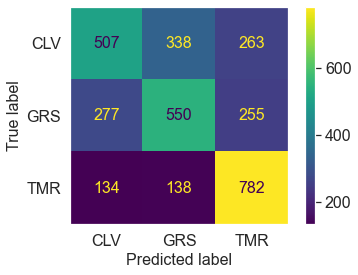

In [33]:
predict_eval(ridge, y, y_pred)

In [34]:
#This function is used repeatedly to compute all metrics
def printMetrics(y, y_pred):
    #classification evaluation measures
    print('\n==============================================================================')
    #print("Accuracy: ", metrics.accuracy_score(y, y_pred))
    #print("Confusion matrix: \n", metrics.confusion_matrix(y, y_pred))
    print("Classification report:\n ", metrics.classification_report(y, y_pred))

In [35]:
#printMetrics(y, ridge_predictions)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


X_train:
Accuracy: 0.5760534429599178


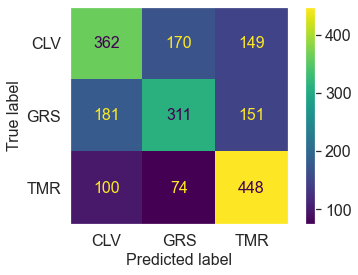


Intercept: 
 [ -1.17224596 -30.6760794   30.84832536]

Features and coeficients: [('col1', array([ 0.24947647,  0.17487266,  0.14099018, ..., -0.28276296,
       -0.28081812, -0.27420264])), ('col2', array([0.64661004, 0.66260573, 0.67634284, ..., 0.00955889, 0.01746   ,
       0.02120377])), ('col3', array([-0.89608651, -0.83747839, -0.81733302, ...,  0.27320407,
        0.26335812,  0.25299887]))]


In [37]:
# Train on the training sample and test on the train and test sample.
ridge = RidgeClassifier().fit(X_train, y_train)
print("X_train:")
y_pred = ridge.predict(X_train)
predict_eval(ridge, y_train, y_pred)

# Print the weights learned for each feature.
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])

In [38]:
#print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, y_pred)


Classification report:
                precision    recall  f1-score   support

         CLV       0.56      0.53      0.55       681
         GRS       0.56      0.48      0.52       643
         TMR       0.60      0.72      0.65       622

    accuracy                           0.58      1946
   macro avg       0.57      0.58      0.57      1946
weighted avg       0.57      0.58      0.57      1946



X_test:
Accuracy: 0.46687211093990755


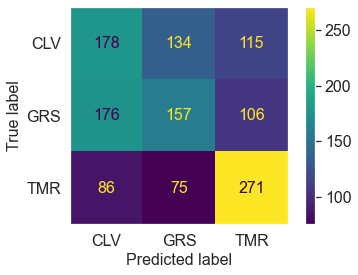


Classification report:
                precision    recall  f1-score   support

         CLV       0.40      0.42      0.41       427
         GRS       0.43      0.36      0.39       439
         TMR       0.55      0.63      0.59       432

    accuracy                           0.47      1298
   macro avg       0.46      0.47      0.46      1298
weighted avg       0.46      0.47      0.46      1298



In [39]:
# Predicted price on test set
print("X_test:")
y_pred = ridge.predict(X_test)
predict_eval(ridge, y_test, y_pred)
printMetrics(y_test, y_pred)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head().sort_values('kappa_casein'))

In [40]:
error_measures = ['accuracy']
scores = cross_validate(RidgeClassifier(), X, y, scoring=error_measures, cv=3)
scores

{'fit_time': array([0.16221905, 0.18793535, 0.13792014]),
 'score_time': array([0.01722288, 0.01575875, 0.01728296]),
 'test_accuracy': array([0.48983364, 0.5013876 , 0.48843663])}

In [41]:
def printMetricsClassifCV(clf, X, y, metrics = ['acc']):
    #run cross-validation to compute the rmse for different folds, using different regression algorithms
    print('\n==============================================================================')
    scores = cross_validate(clf, X, y, scoring=metrics, cv=4)
    scores
    #print("MAE: ", -scores['test_neg_mean_absolute_error'])
    print("Acc: ", scores['test_accuracy'])

In [42]:
list_clf = [
            #RidgeClassifier(), 
            #RidgeClassifierCV(), 
            #RidgeClassifierCV(normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-4, 4, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-10, 10, 10), normalize=True), 
            #LogisticRegression(penalty='l2'), LogisticRegression(penalty='l1'), 
            #GaussianNB(), 
            LinearDiscriminantAnalysis(), 
            #QuadraticDiscriminantAnalysis(), LinearSVC(),
            #RandomForestClassifier(n_estimators=100), 
            #GradientBoostingClassifier(n_estimators=100),
            #ExtraTreesClassifier(n_estimators=100)
            #RotationForestClassifier(n_estimators=25, n_features_per_subset=3, rotation_algo='randomized'),
            #KNeighborsClassifier(n_neighbors=3),  
            #MLPClassifier(alpha=1, max_iter=1000), 
            #SVC(kernel="linear", C=0.025), 
            #LinearSVC(C=0.001),
            #SVC(C=500.0, kernel="poly", degree=2, coef0=0, gamma=1.0)
            #SVC(gamma=2, C=1)
            ]
            
            
def algoCV(list_clf, X, y, folds = 3, error_measures = ['accuracy']):
    
    algos_df = pd.DataFrame({"algo":[], "acc": []})

    for algo in list_clf:
        print(algo)
        scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        
        algos_df = algos_df.append({"algo":str(algo), "acc": np.mean(acc)}, ignore_index=True)
             
        print("acc: ", acc)
        print("accCV: ", np.mean(acc))
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))
    algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    
if __name__ == "__main__":
    
    algoCV(list_clf, X, y)
    

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)
acc:  [0.75600739 0.73820537 0.73635523]
accCV:  0.7435226619199152


RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                  normalize=True)
acc:  [0.76617375 0.76595745 0.7493062 ]
accCV:  0.760479132361298


RidgeClassifierCV(alphas=array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06]),
                  normalize=True)
acc:  [0.76617375 0.7493062  0.74375578]
accCV:  0.7530785773196699


LinearDiscriminantAnalysis()
acc:  [0.74861368 0.74190564 0.75208

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


Accuracy: 0.7719568567026194


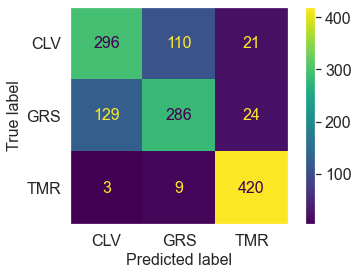

In [44]:
#Without feature selection
clf = Pipeline([
    #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
    #('selector', RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7372881355932204


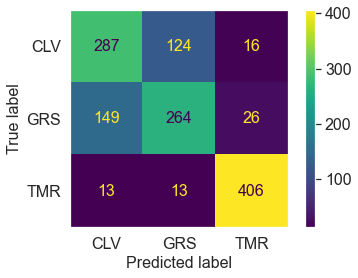

In [45]:
#Without feature selection
clf = Pipeline([
 # ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
 #('selector', RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
  ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7719568567026194


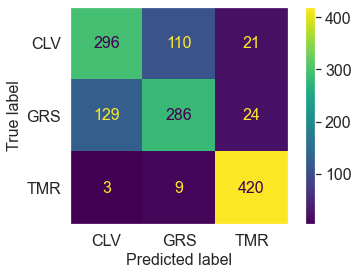

col1 [12.31144564 -8.07238117 -4.23906447]
col2 [-5.60578064 11.69962293 -6.09384229]
col3 [-9.98332534 13.00672642 -3.02340108]
col4 [-2.69742595  2.95022275 -0.2527968 ]
col5 [ 8.10431386 -8.34018146  0.23586759]
col6 [ 14.04802176 -12.54033473  -1.50768702]
col7 [10.59347865 -7.09513985 -3.4983388 ]
col8 [-0.90371311  4.06636483 -3.16265173]
col9 [-14.01713736  13.15782483   0.85931252]
col10 [-21.02476343  13.51311078   7.51165265]
col11 [-17.96267572   4.24383837  13.71883735]
col12 [-7.41387961 -8.96774168 16.38162128]
col13 [  3.4142175  -17.96157836  14.54736086]
col14 [  7.91042006 -18.04174162  10.13132156]
col15 [  4.72546672 -11.38704039   6.66157368]
col16 [-1.5031915 -5.2503626  6.7535541]
col17 [-4.20966845 -5.90895773 10.11862618]
col18 [ -0.50636098 -13.37766356  13.88402454]
col19 [  6.62436765 -21.45686672  14.83249908]
col20 [ 11.03062765 -22.4620534   11.43142575]
col21 [  8.24196433 -12.74233989   4.50037556]
col22 [-1.17419516  4.19801956 -3.0238244 ]
col23 [-12.

col557 [ 3.82027819 -5.97098216  2.15070397]
col558 [-0.28373417  0.31415137 -0.0304172 ]
col559 [-4.5388353   5.46615352 -0.92731822]
col560 [-2.05780109  1.80857031  0.24923078]
col561 [ 3.94228073 -4.23237838  0.29009766]
col562 [ 2.03220593 -1.00318077 -1.02902515]
col563 [-3.41547407  3.55743602 -0.14196194]
col564 [-0.73216878 -0.76219965  1.49436843]
col565 [ 1.8807053  -1.42270866 -0.45799664]
col566 [-0.20519374  0.69784887 -0.49265513]
col567 [-0.36908958  0.31784534  0.05124424]
col568 [ 0.54690561 -0.37119835 -0.17570727]
col569 [-0.82945007  0.18315396  0.64629611]
col570 [-0.02590188  0.3921834  -0.36628152]
col571 [ 0.29145149  0.0019753  -0.29342679]
col572 [-0.56785875 -0.31863466  0.88649341]
col573 [ 0.79838537 -0.52309797 -0.27528741]
col574 [ 1.22809482  0.55120501 -1.77929983]
col575 [-1.71255699  0.61578047  1.09677652]
col576 [-1.96266329 -0.71491795  2.67758124]
col577 [ 1.12159288 -0.04793159 -1.07366129]
col578 [ 2.0146498   1.35838376 -3.37303356]
col579 [-0

col954 [ 7.35033354  0.38888428 -7.73921782]
col955 [13.23286942 -4.62795722 -8.6049122 ]
col956 [14.02211314 -7.25242847 -6.76968467]
col957 [ 7.49526575 -6.59108759 -0.90417816]
col958 [-4.33052221 -3.76788101  8.09840322]
col959 [-16.14461572  -0.76543262  16.91004834]
col960 [-22.32767331   1.13625685  21.19141645]
col961 [-20.23099886   2.21834336  18.0126555 ]
col962 [-11.78329056   3.9231173    7.86017326]
col963 [-2.4082689   7.52342626 -5.11515736]
col964 [  2.16644928  12.82481376 -14.99126304]
col965 [ -0.67094656  17.84810607 -17.17715951]
col966 [ -8.83447988  19.79178979 -10.95730991]
col967 [-16.77816343  16.72349667   0.05466676]
col968 [-18.82977866   8.95842053   9.87135813]
col969 [-12.62603681  -0.7468101   13.3728469 ]
col970 [-0.59979365 -8.36239999  8.96219364]
col971 [ 11.3524861  -10.51944573  -0.83304037]
col972 [ 17.21976802  -6.20000606 -11.01976197]
col973 [ 14.27411702   2.68770234 -16.96181936]
col974 [  4.55993499  12.1449661  -16.70490108]
col975 [ -6.3

In [46]:
clf = RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(ridge, y_test, y_pred)

for idx in range(0, len(features)):
    #if selector.get_support()[idx]:
    print(features[idx], clf.coef_[:,idx])

Accuracy: 0.7958397534668721


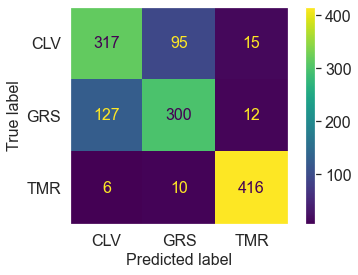


Classification report:
                precision    recall  f1-score   support

         CLV       0.70      0.74      0.72       427
         GRS       0.74      0.68      0.71       439
         TMR       0.94      0.96      0.95       432

    accuracy                           0.80      1298
   macro avg       0.79      0.80      0.79      1298
weighted avg       0.79      0.80      0.79      1298



In [47]:
#Testing feature selection
#th = "median"
th = "mean"

clf = Pipeline([
   # ('scaler', StandardScaler()),
   # ('feature selector', SelectKBest(mutual_info_classif, k=800)),
    ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = th)),  
   #  ('fpoly', PolynomialFeatures(degree=2)),
  #  ('feature_selection2', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = th)),  
   #("fspline", SplineTransformer(n_knots=4, degree=3)),
 # ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
     ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)

In [48]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = "median")),
   #('selector', RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
    ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True),
                                 threshold='median')),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.77449168 0.78168363 0.75670675]
accCV:  0.7709606871162288
time fit+score: 1.6770626703898113




Accuracy: 0.8258859784283513


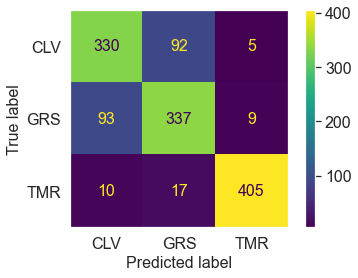


Classification report:
                precision    recall  f1-score   support

         CLV       0.76      0.77      0.77       427
         GRS       0.76      0.77      0.76       439
         TMR       0.97      0.94      0.95       432

    accuracy                           0.83      1298
   macro avg       0.83      0.83      0.83      1298
weighted avg       0.83      0.83      0.83      1298



In [49]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = "mean")),
  ('fpoly', PolynomialFeatures(degree=2)),
    ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)

In [50]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
    ('fpoly', PolynomialFeatures(degree=2)),
  ('classification', LinearDiscriminantAnalysis())
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('fpoly', PolynomialFeatures()),
                ('classification', LinearDiscriminantAnalysis())])
acc:  [0.84565619 0.84273821 0.84458834]
accCV:  0.8443275805759369
time fit+score: 98.37282546361287




In [51]:
selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)).fit(X_train, y_train)
#selector.estimator_.coef_
print("threshold: ", selector.threshold_)
print("number of selected features: ", selector.get_support().sum())
print("coefs: ", selector.estimator_.coef_)
#selector.get_support()

threshold:  56.785128240863685
number of selected features:  312
coefs:  [[ 12.31144564  -5.60578064  -9.98332534 ... -11.12499045 -15.53104525
  -16.16260089]
 [ -8.07238117  11.69962293  13.00672642 ...   8.123713    12.66065365
   15.77988069]
 [ -4.23906447  -6.09384229  -3.02340108 ...   3.00127745   2.8703916
    0.38272021]]


In [165]:
#selector = RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
#print("threshold: ", selector.threshold_)
#print("number of selected features: ", selector.get_support().sum())
#print("coefs: ", selector.estimator_.coef_)

In [166]:
#for idx in range(0, len(selector.get_support())):
    #if selector.get_support()[idx]:
#    print(features[idx], selector.estimator_.coef_[:,idx])

In [167]:
#import numpy.ma as ma
#features_selected = ma.masked_where(selector.get_support(), features)
#for idx in range(0, len(selector.get_support())):
#    if selector.get_support()[idx]:
#        print(features[idx])

In [76]:
#for idx in range(0, len(selector.get_support())):
#    if selector.get_support()[idx]:
#        print(features[idx], selector.estimator_.coef_[:,idx])

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.
+ Addind features selection + poly2 features improves the accuracy by 3% (('fpoly', PolynomialFeatures(degree=2))).

In [77]:
class IntervalSelector(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, start = 0, end = 10, return_timeseries = True):        
        self.start = start
        self.end = end
        self.return_timeseries = return_timeseries
            
            
    def fit(self, X, y = None):        
        return self    
    
    def transform(self, X, y = None):             
        if self.return_timeseries:
            return from_2d_array_to_nested(X.iloc[:,self.start:self.end])
        else:
            return X.iloc[:,self.start:self.end]

----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.714175654853621


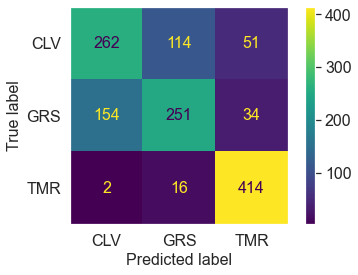

----------------------
Interval: 206 - 535
----------------------
Accuracy: 0.734206471494607


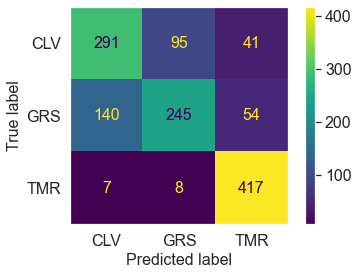

----------------------
Interval: 729 - 747
----------------------
Accuracy: 0.3320493066255778


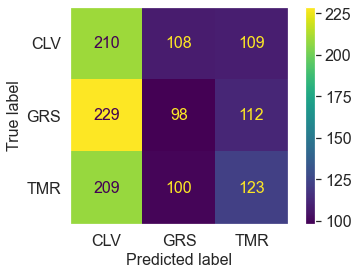

In [78]:
#Water region removal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,535),(729,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, y_test, y_pred)

Accuracy: 0.7835130970724191


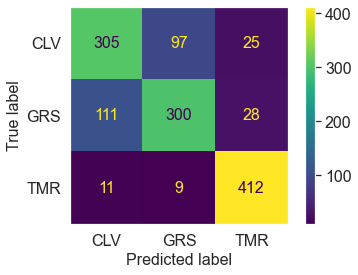

In [79]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535]]


clf = Pipeline([
    ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
    #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True, class_weight='balanced'))
    ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7950693374422187


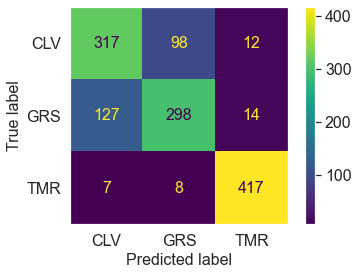

In [80]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171]]


clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

In [54]:

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
       ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])

algo = clf
folds = 3
print(algo)

#scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535]], y, scoring=error_measures, cv=folds)


#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.77356747 0.7826087  0.75208141]
accCV:  0.7694191898033758
time fit+score: 0.3546326955159505




In [56]:
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
     # ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])

algo = clf
folds = 3
print(algo)

#scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535]], y, scoring=error_measures, cv=folds)

#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
#print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('classification', LinearDiscriminantAnalysis())])
acc:  [0.78003697 0.78723404 0.76688252]
accCV:  0.7780511757728719
time fit+score: 0.2678130467732747




----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.687211093990755


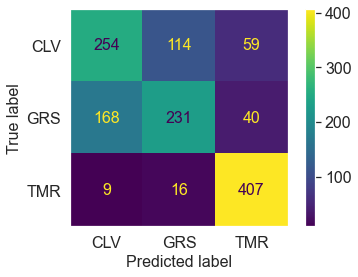

----------------------
Interval: 206 - 535
----------------------
Accuracy: 0.714175654853621


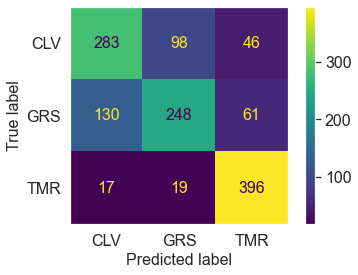

----------------------
Interval: 729 - 747
----------------------
Accuracy: 0.33975346687211094


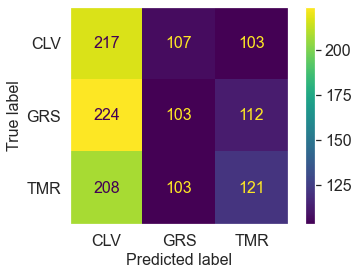

In [172]:
#Water region removal + feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,535),(729,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, y_test, y_pred)

Accuracy: 0.7842835130970724


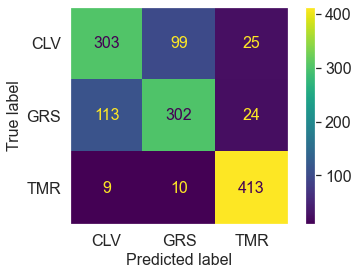

In [81]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('fpoly', PolynomialFeatures(degree=2)),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.8328197226502311


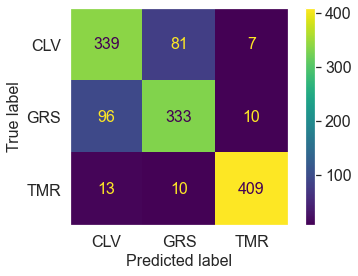

In [82]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306]]


clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
       ('fpoly', PolynomialFeatures(degree=2)),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

In [175]:
clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
     ('fpoly', PolynomialFeatures(degree=2)),
      ('classification', LinearDiscriminantAnalysis())
    ])

algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
#scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535]], y, scoring=error_measures, cv=folds)

#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('fpoly', PolynomialFeatures()),
                ('classification', LinearDiscriminantAnalysis())])
acc:  [0.84288355 0.85291397 0.83626272]
accCV:  0.8440200790783278
time fit+score: 41.48094455401103




# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.
+Best result so far: original data + feature selection (SelectFromModel()) + poly2 + Ridge or LDA

In [52]:
# Try some noise removal before feature selection and learning
# Ranking windows to do automatic water region removal
# Ideas to test: contiguous windows of fixed size, contiguous windows of random size, non-contiguous windows (essentially random feature subset selection of varying size)
# This looks to simulate watere region removal, finding regions that are noisy and regions with useful signal
# part of this code extends the open source code from here: https://github.com/EannaCurran/FYP-Time-Series-Classification-For-GWAS-Data
def rankedWindows(X, y, runs, windowSize, classifier):

    results = {}
    
    if len(X.columns) % windowSize == 0:
        numberOfWindows = len(X.columns) // windowSize
    else:
        numberOfWindows = (len(X.columns) // windowSize) + 1
    
    print(numberOfWindows)
    
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.4, random_state = 0)
        
    for k in range(1, runs+1):

        #print(f"Run {k}")

        validationScores = []
        
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, test_size=0.4)

        for n in range(0, numberOfWindows):               
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            if windowEnd > len(X.columns): 
                windowEnd = len(X.columns)          
            #print("windowStart:", windowStart)
            #print("windowEnd:", windowEnd)
            
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if (classifier == "MiniRocket"):
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                clf.fit(xTrainTransform, yTrainSplit)
                xValidateTransform = minirocket.transform(xValidateWindowSeries)
                y_pred = clf.predict(xValidateTransform)
                score = accuracy_score(yValidate, y_pred)
            
            
            elif (classifier == "RidgeClassifierCV"):
               # clf = RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True)
                clf = Pipeline([
                 # ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
                 #  ('fpoly', PolynomialFeatures(degree=2)),
                 # ('classification', LinearDiscriminantAnalysis())
                     ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
                ])
                clf.fit(xTrainWindow, yTrainSplit)
                y_pred = clf.predict(xValidateWindow)
                score = accuracy_score(yValidate, y_pred)
                
            validationScores.append(score)
            #print(validationScores)
            #print(windowStart, windowEnd)
            #print(score)
            
    
        for n in range(0, numberOfWindows):
            if n in results:
                results[n] += validationScores[n]
            else:
                results[n] = validationScores[n]
            #print(results)
             
        #print(results)       
                   
    #print(validationScores)
    for n in range(0, numberOfWindows):
        results[n] = results[n] / runs
    #print(results)
    
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        if newKeyEnd > len(X.columns): 
                newKeyEnd = len(X.columns) 
        updatedKeyResults[f"{newKeyStart}:{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [53]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 50, classifier = "RidgeClassifierCV")

22


In [54]:
ridge_windows

[('100:150', 0.6320924261874197),
 ('0:50', 0.5894736842105264),
 ('500:550', 0.548395378690629),
 ('50:100', 0.5458279845956353),
 ('450:500', 0.5360718870346599),
 ('200:250', 0.48035943517329915),
 ('250:300', 0.42875481386392816),
 ('150:200', 0.4159178433889602),
 ('350:400', 0.3969191270860077),
 ('300:350', 0.3958921694480103),
 ('400:450', 0.39358151476251607),
 ('900:950', 0.375609756097561),
 ('850:900', 0.3740693196405648),
 ('800:850', 0.3614890885750962),
 ('1000:1050', 0.358408215661104),
 ('700:750', 0.3573812580231065),
 ('750:800', 0.355584082156611),
 ('550:600', 0.3545571245186136),
 ('950:1000', 0.35070603337612327),
 ('1050:1060', 0.3504492939666239),
 ('650:700', 0.345571245186136),
 ('600:650', 0.34428754813863927)]

In [55]:
# given a list of ranked windows, return the index of columns included in the windows up to a given window
# eg for index = 1, return the columns corresponding to the first window, for idx = 2, return columns for first 2 windows
def evalWindows(ridge_windows, idx):
#idx = 22

    #print("idx: ", idx)
    subset_columns = np.array([])

    for w in ridge_windows[:idx]:
        #print(w[0])
        start = int(w[0].split(':')[0])
        end = int(w[0].split(':')[1])
        #if end > len(X.columns): 
        #    end = len(X.columns)
        #print(np.r_[start+1:end+1])
        #print(X_train.iloc[:, np.r_[start:end]].columns)
        #print(X_train.iloc[:, np.r_[start:end]].columns.to_list())
        #subset_columns = subset_columns.union(X_train.iloc[:, np.r_[start:end]].columns)
        subset_columns = np.concatenate((subset_columns, np.array(np.r_[start+1:end+1])), axis=None)
    
    #print(subset_columns)
    #print(np.sort(subset_columns))

    subset_columns = np.sort(subset_columns)

    #print(["col" + str(int(item)) for item in subset_columns])
    subset_index = pd.Index(["col" + str(int(item)) for item in subset_columns])
    #print(subset_index)
    return subset_index 
    

In [56]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 50, classifier = "RidgeClassifierCV")
algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    subset_index = evalWindows(ridge_windows, idx)

    X_train_auto_windows = X_train[subset_index]
    X_test_auto_windows = X_test[subset_index]

    clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        ])
    clf.fit(X_train_auto_windows, y_train)
    y_pred = clf.predict(X_test_auto_windows)
    #predict_eval(clf, y_test, y_pred)
    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
print(algos_df.sort_values('acc', ascending=False))
    

22
   window_idx       acc
9          10  0.791217
11         12  0.790447
15         16  0.787365
13         14  0.785824
10         11  0.785824
20         21  0.784284
12         13  0.784284
21         22  0.782743
7           8  0.781972
19         20  0.781202
8           9  0.778120
18         19  0.778120
17         18  0.777350
16         17  0.776579
14         15  0.775039
6           7  0.755778
4           5  0.732666
5           6  0.723421
2           3  0.718028
3           4  0.708783
1           2  0.688752
0           1  0.628659


In [57]:
# evaluate the best idx for ranked windows and rank in order of accuracy
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    subset_index = evalWindows(ridge_windows, idx)

    X_train_auto_windows = X_train[subset_index]
    X_test_auto_windows = X_test[subset_index]

    clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        #('feature_selection', SelectKBest(k = 50)),    
        ('classification', LinearDiscriminantAnalysis())
        ])
    clf.fit(X_train_auto_windows, y_train)
    y_pred = clf.predict(X_test_auto_windows)
    #predict_eval(clf, y_test, y_pred)
    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
print(algos_df.sort_values('acc', ascending=False))
    

12
   window_idx       acc
9          10  0.805085
8           9  0.801233
10         11  0.798921
11         12  0.795840
3           4  0.787365
4           5  0.786595
6           7  0.783513
5           6  0.782743
7           8  0.782743
2           3  0.731125
1           2  0.716487
0           1  0.645609


In [58]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    
    subset_index = evalWindows(ridge_windows, idx)
     
    #X_train_auto_windows = X_train[subset_index]
    #X_test_auto_windows = X_test[subset_index]
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
      #('classification', LinearDiscriminantAnalysis())
    ])

    algo = clf
    folds = 3
    #print(algo)

    scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
    #scores
    acc = scores['test_accuracy']
    fit_time = np.mean(scores['fit_time'])
    score_time = np.mean(scores['score_time'])
    #print("acc: ", acc)
    #print("accCV: ", np.mean(acc))
    algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
    #print("fit_time: ", fit_time)
    #print("score_time: ", score_time)
    #print("time fit+score:", fit_time + score_time)
    #print("\n")
    
print(algos_df.sort_values('acc', ascending=False))
#algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    

12
   window_idx       acc
10         11  0.778358
11         12  0.777434
8           9  0.777433
9          10  0.777124
7           8  0.775893
6           7  0.772500
5           6  0.769421
4           5  0.766644
3           4  0.716398
2           3  0.708386
1           2  0.692041
0           1  0.638710


In [59]:
#for wlength in range(10, 101, 10):
#    print("window size: ", wlength)
#    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
#    print(ridge_windows[:10])
    
#    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

#    for idx in range(1,len(ridge_windows)+1):
#        subset_index = evalWindows(ridge_windows, idx)

#        X_train_auto_windows = X_train[subset_index]
#        X_test_auto_windows = X_test[subset_index]

#        clf = Pipeline([
#          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
#          ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
#        ])
#        clf.fit(X_train_auto_windows, y_train)
#        y_pred = clf.predict(X_test_auto_windows)
        #predict_eval(clf, y_test, y_pred)
#        algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
#    print(algos_df.sort_values('acc', ascending=False))

In [96]:
#for wlength in range(10, 101, 10):
for wlength in [90]:
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:5])
    
    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
        subset_index = evalWindows(ridge_windows, idx)

        X_train_auto_windows = X_train[subset_index]
        X_test_auto_windows = X_test[subset_index]

        clf = Pipeline([
         # ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', LinearDiscriminantAnalysis())
        ])
        clf.fit(X_train_auto_windows, y_train)
        y_pred = clf.predict(X_test_auto_windows)
        #predict_eval(clf, y_test, y_pred)
        algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  90
12
[('90:180', 0.637997432605905), ('0:90', 0.6374839537869063), ('450:540', 0.592811296534018), ('270:360', 0.4685494223363286), ('180:270', 0.46469833119383824)]
   window_idx       acc
4           5  0.792758
3           4  0.788136
6           7  0.788136
5           6  0.782743
7           8  0.780431
8           9  0.774268
9          10  0.755778
2           3  0.750385
10         11  0.748844
11         12  0.737288
1           2  0.722650
0           1  0.673344


In [ ]:
for wlength in range(50, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])

    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
    
        subset_index = evalWindows(ridge_windows, idx)
     
        clf = Pipeline([
            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
              #('classification', LinearDiscriminantAnalysis())
        ])

        algo = clf
        folds = 3
        #print(algo)

        scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        #print("acc: ", acc)
        #print("accCV: ", np.mean(acc))
        algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        #print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))

In [60]:
#for wlength in range(10, 101, 10):
for wlength in [90]:
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])

    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
    
        subset_index = evalWindows(ridge_windows, idx)
     
        clf = Pipeline([
            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
            #('fpoly', PolynomialFeatures(degree=2)),
            ('classification', LinearDiscriminantAnalysis())
        ])

        algo = clf
        folds = 3
        #print(algo)

        scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        #print("acc: ", acc)
        #print("accCV: ", np.mean(acc))
        algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        #print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  90
12
[('90:180', 0.6446726572528882), ('0:90', 0.6385109114249038), ('450:540', 0.5843388960205391), ('180:270', 0.4757381258023107), ('270:360', 0.47086007702182286), ('360:450', 0.4326059050064185), ('900:990', 0.3848523748395379), ('810:900', 0.382028241335045), ('720:810', 0.37894736842105264), ('990:1060', 0.3738125802310655)]
   window_idx       acc
7           8  0.781749
8           9  0.780517
10         11  0.779285
11         12  0.778666
6           7  0.777743
5           6  0.775281
9          10  0.775277
4           5  0.767264
3           4  0.723179
2           3  0.721637
1           2  0.703135
0           1  0.646107


# Make predictions using best model on the test data

idx = 10, wsize = 90

clf = Pipeline([

            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            
            ('classification', LinearDiscriminantAnalysis())
        ])

In [61]:
training_df.shape

(3244, 1061)

12
X_train
Accuracy: 0.9501541623843782


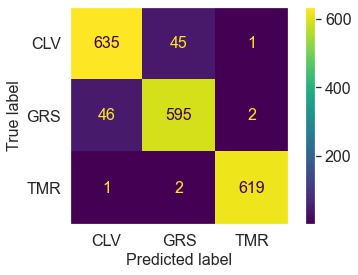


Classification report:
                precision    recall  f1-score   support

         CLV       0.93      0.93      0.93       681
         GRS       0.93      0.93      0.93       643
         TMR       1.00      1.00      1.00       622

    accuracy                           0.95      1946
   macro avg       0.95      0.95      0.95      1946
weighted avg       0.95      0.95      0.95      1946

train60 class distrib:
 CLV    681
GRS    643
TMR    622
Name: Diet, dtype: int64
train60 class distrib:
 CLV    0.349949
GRS    0.330421
TMR    0.319630
Name: Diet, dtype: float64
train60 predicted class distrib:
 CLV    682
GRS    642
TMR    622
dtype: int64
train60 predicted class distrib:
 CLV    0.350462
GRS    0.329908
TMR    0.319630
dtype: float64
X_test
Accuracy: 0.8382126348228043


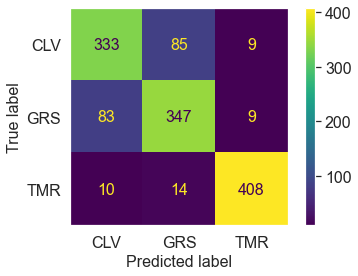


Classification report:
                precision    recall  f1-score   support

         CLV       0.78      0.78      0.78       427
         GRS       0.78      0.79      0.78       439
         TMR       0.96      0.94      0.95       432

    accuracy                           0.84      1298
   macro avg       0.84      0.84      0.84      1298
weighted avg       0.84      0.84      0.84      1298

test40 class distrib:
 CLV    427
GRS    439
TMR    432
Name: Diet, dtype: int64
test40 class distrib:
 CLV    0.328968
GRS    0.338213
TMR    0.332820
Name: Diet, dtype: float64
test40 predicted class distrib:
 CLV    426
GRS    446
TMR    426
dtype: int64
test40 predicted class distrib:
 CLV    0.328197
GRS    0.343606
TMR    0.328197
dtype: float64
['GRS' 'CLV' 'GRS' ... 'CLV' 'GRS' 'GRS']
final test pred class distrib:
 CLV    372
GRS    364
TMR    341
dtype: int64
final test pred class distrib:
 CLV    0.345404
GRS    0.337976
TMR    0.316620
dtype: float64
  Diet      col1      co

In [63]:
# Auto windows removal, feature selection, poly2, LDA
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

#algos_df = pd.DataFrame({"window_idx":[], "acc": []})

#for idx in range(1,len(ridge_windows)+1):
#take the best window size and idx of windows to use
subset_index = evalWindows(ridge_windows, idx = 8)

X_train_auto_windows = X_train[subset_index]
X_test_auto_windows = X_test[subset_index]

clf = Pipeline([
         ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
         #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        #('feature_selection', SelectKBest(k = 50)),    
        ('fpoly', PolynomialFeatures(degree=2)),
        ('classification', LinearDiscriminantAnalysis())
        ])

clf.fit(X_train_auto_windows, y_train)
print("X_train")
y_pred = clf.predict(X_train_auto_windows)
predict_eval(clf, y_train, y_pred)
printMetrics(y_train, y_pred)
print("train60 class distrib:\n", y_train.value_counts().sort_index(ascending=True))
print("train60 class distrib:\n", y_train.value_counts(normalize=True).sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

print("X_test")
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)
print("test40 class distrib:\n", y_test.value_counts().sort_index(ascending=True))
print("test40 class distrib:\n", y_test.value_counts(normalize=True).sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

X_train_full_auto_windows = X[subset_index]
X_test_full_auto_windows = test_df[features][subset_index]

clf.fit(X_train_full_auto_windows, y)
y_pred_test = clf.predict(X_test_full_auto_windows)
#print(X_test_full_auto_windows)
print(y_pred_test)
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts().sort_index(ascending=True) )
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts(normalize=True).sort_index(ascending=True))

test_df_pred = pd.concat([pd.DataFrame(y_pred_test, columns=['Diet'], index=X_test_full_auto_windows.index), X_test_full_auto_windows], axis=1)
print(test_df_pred.head(3))

[[-3.08517176  0.97372984]
 [ 3.38831493 -0.92335318]
 [ 0.56588623 -0.90518118]
 [ 0.17852674 -0.54724111]
 [-1.5312918  -2.00152638]
 [-2.99531426  2.36471223]
 [-1.66495899 -0.38666109]
 [-2.7246979   0.3848521 ]
 [-2.35712355  0.54211603]
 [ 2.21257686 -1.10774797]] 
 1341    CLV
2455    TMR
2413    GRS
2240    GRS
305     GRS
1118    CLV
2586    GRS
2670    CLV
1191    CLV
2121    TMR
Name: Diet, dtype: object


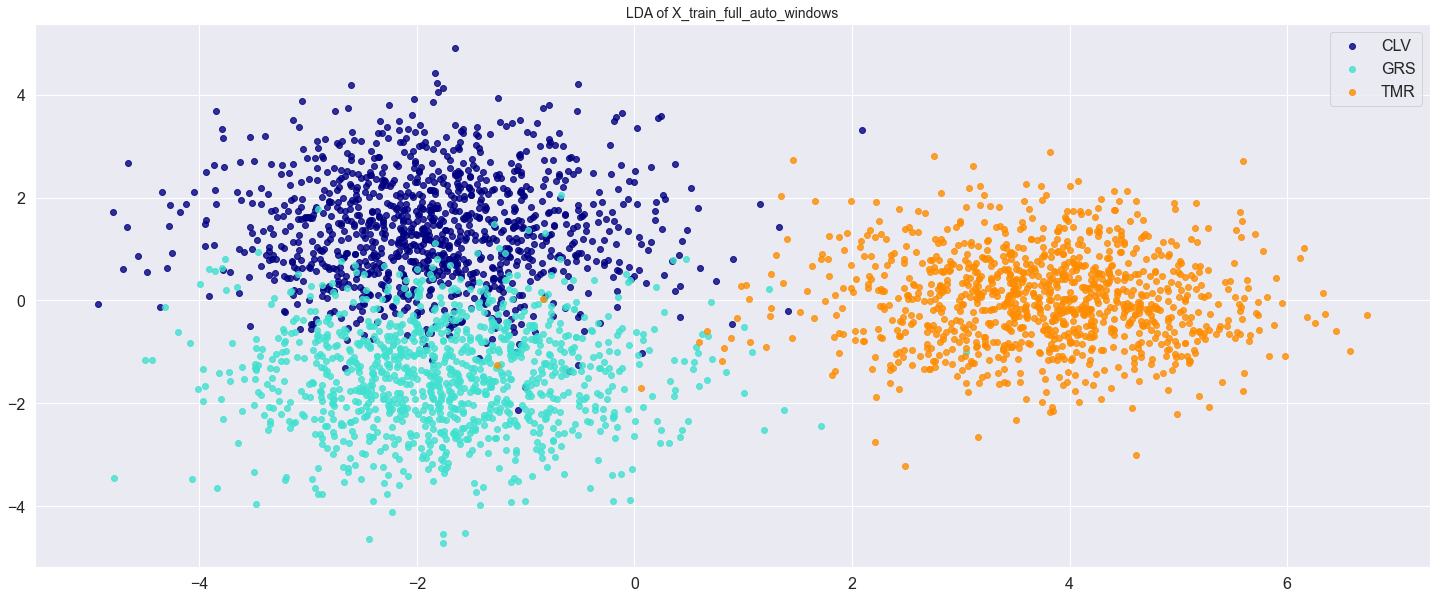

In [64]:
#print("columns after window removal:", X_train_full_auto_windows.columns)
#selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)).fit(X_train_full_auto_windows, y)
#selector.estimator_.coef_
#print("threshold: ", selector.threshold_)
#print("number of selected features: ", selector.get_support().sum())
#print("coefs: ", selector.estimator_.coef_)

#top_features = {}
#for idx in range(0, len(selector.get_support())):
#    if selector.get_support()[idx]:
        #print(features[idx], selector.estimator_.coef_[:,idx])
#        sum_coefs = 0
#        for coef in selector.estimator_.coef_[:,idx]:
#            sum_coefs += np.abs(coef)
#        top_features[features[idx]] = sum_coefs
        
#print(top_features)   
#print(sorted(top_features.items(), key=lambda x: x[1], reverse=True)[:70])

#for i in sorted(top_features.items(), key=lambda x: x[1], reverse=True)[:5]:
#    print(i)
    
#lda = LinearDiscriminantAnalysis(n_components=2)
#X_train_new = X_train_full_auto_windows[X_train_full_auto_windows.columns[selector.get_support()]]
#X_r2 = lda.fit(X_train_new, y).transform(X_train_new)

# Visualise the training data according to the 2 LDA components trained above
X_r2 = clf.fit(X_train_full_auto_windows, y).transform(X_train_full_auto_windows)

print(X_r2[:10], "\n", y[:10])

target_names = unique_labels(y)

plt.figure(figsize=(25, 10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

labelencoder = LabelEncoder()
yn = labelencoder.fit_transform(y)

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[yn == i, 0], X_r2[yn == i, 1], alpha=0.8, color=color, label=target_name)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of X_train_full_auto_windows")

plt.show()

X_train
Accuracy: 0.9660842754367934


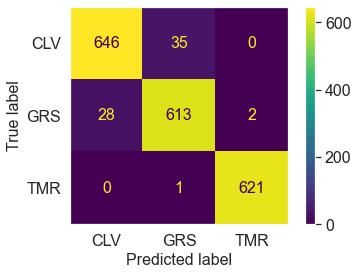


Classification report:
                precision    recall  f1-score   support

         CLV       0.96      0.95      0.95       681
         GRS       0.94      0.95      0.95       643
         TMR       1.00      1.00      1.00       622

    accuracy                           0.97      1946
   macro avg       0.97      0.97      0.97      1946
weighted avg       0.97      0.97      0.97      1946

train60 class distrib:
 CLV    681
GRS    643
TMR    622
Name: Diet, dtype: int64
train60 class distrib:
 CLV    0.349949
GRS    0.330421
TMR    0.319630
Name: Diet, dtype: float64
train60 predicted class distrib:
 CLV    674
GRS    649
TMR    623
dtype: int64
train60 predicted class distrib:
 CLV    0.346351
GRS    0.333505
TMR    0.320144
dtype: float64
X_test
Accuracy: 0.8258859784283513


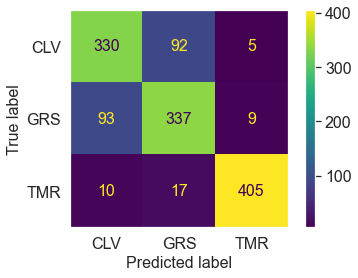


Classification report:
                precision    recall  f1-score   support

         CLV       0.76      0.77      0.77       427
         GRS       0.76      0.77      0.76       439
         TMR       0.97      0.94      0.95       432

    accuracy                           0.83      1298
   macro avg       0.83      0.83      0.83      1298
weighted avg       0.83      0.83      0.83      1298

test40 class distrib:
 CLV    427
GRS    439
TMR    432
Name: Diet, dtype: int64
test40 class distrib:
 CLV    0.328968
GRS    0.338213
TMR    0.332820
Name: Diet, dtype: float64
test40 predicted class distrib:
 CLV    433
GRS    446
TMR    419
dtype: int64
test40 predicted class distrib:
 CLV    0.333590
GRS    0.343606
TMR    0.322804
dtype: float64
['GRS' 'CLV' 'GRS' ... 'CLV' 'GRS' 'GRS']
final test pred class distrib:
 CLV    387
GRS    355
TMR    335
dtype: int64
final test pred class distrib:
 CLV    0.359331
GRS    0.329619
TMR    0.311049
dtype: float64
  Diet      col1      co

In [65]:
# Feature selection, poly2, LDA
clf = Pipeline([
         ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
         #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        #('feature_selection', SelectKBest(k = 50)),    
        ('fpoly', PolynomialFeatures(degree=2)),
        ('classification', LinearDiscriminantAnalysis())
        ])

clf.fit(X_train, y_train)
print("X_train")
y_pred = clf.predict(X_train)
predict_eval(clf, y_train, y_pred)
printMetrics(y_train, y_pred)
print("train60 class distrib:\n", y_train.value_counts().sort_index(ascending=True))
print("train60 class distrib:\n", y_train.value_counts(normalize=True).sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

print("X_test")
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)
print("test40 class distrib:\n", y_test.value_counts().sort_index(ascending=True))
print("test40 class distrib:\n", y_test.value_counts(normalize=True).sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

X_train_full = X
X_test_full = test_df[features]

clf.fit(X_train_full, y)
y_pred_test = clf.predict(X_test_full)
#print(X_test_full_auto_windows)
print(y_pred_test)
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts().sort_index(ascending=True) )
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts(normalize=True).sort_index(ascending=True))

test_df_pred = pd.concat([pd.DataFrame(y_pred_test, columns=['Diet'], index=X_test_full.index), X_test_full], axis=1)
print(test_df_pred.head(3))

In [66]:
# Predicted class on test set
#print("Predictions on the unlabeled test data: \n", y_pred_test)
#test_df_pred.to_csv('27042021-diet-test-predictions-selectfrommodel-poly2-LDA.csv', index=False)



[[-2.82359969  1.29670523]
 [ 2.75446795 -0.81032179]
 [ 0.32125555 -1.35647485]
 [-0.47619833 -1.88984322]
 [-1.60573871 -1.7500228 ]
 [-2.79798318  1.16014784]
 [-1.66152893  0.40308701]
 [-2.26862004  0.83690479]
 [-3.02395714  2.04239175]
 [ 2.92198056 -1.1071578 ]] 
 1341    CLV
2455    TMR
2413    GRS
2240    GRS
305     GRS
1118    CLV
2586    GRS
2670    CLV
1191    CLV
2121    TMR
Name: Diet, dtype: object


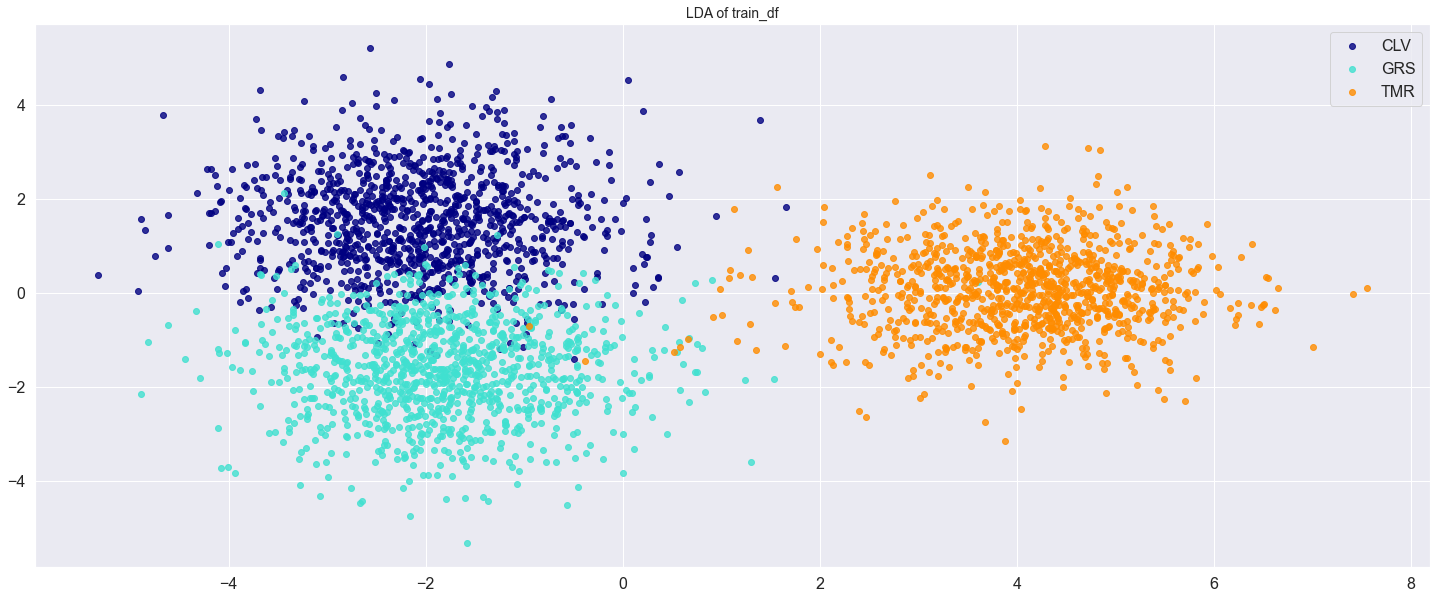

In [67]:
# Visualise the training data according to the 2 LDA components trained above
X_r2 = clf.fit(X, y).transform(X)

print(X_r2[:10], "\n", y[:10])

target_names = unique_labels(y)

plt.figure(figsize=(25, 10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

labelencoder = LabelEncoder()
yn = labelencoder.fit_transform(y)

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[yn == i, 0], X_r2[yn == i, 1], alpha=0.8, color=color, label=target_name)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of train_df")

plt.show()


[[-1.63078275 -1.08206747]
 [-3.09832734  1.38239017]
 [-3.59918615 -2.32222681]
 [-2.66674138 -1.89284515]
 [-2.16425247 -1.25504602]
 [-3.59792361 -1.20209387]
 [ 0.13686904  0.51144237]
 [-2.35243965 -2.88452245]
 [-3.22495999 -1.07016574]
 [-1.08019194  0.19502748]] 
 1341    CLV
2455    TMR
2413    GRS
2240    GRS
305     GRS
1118    CLV
2586    GRS
2670    CLV
1191    CLV
2121    TMR
Name: Diet, dtype: object


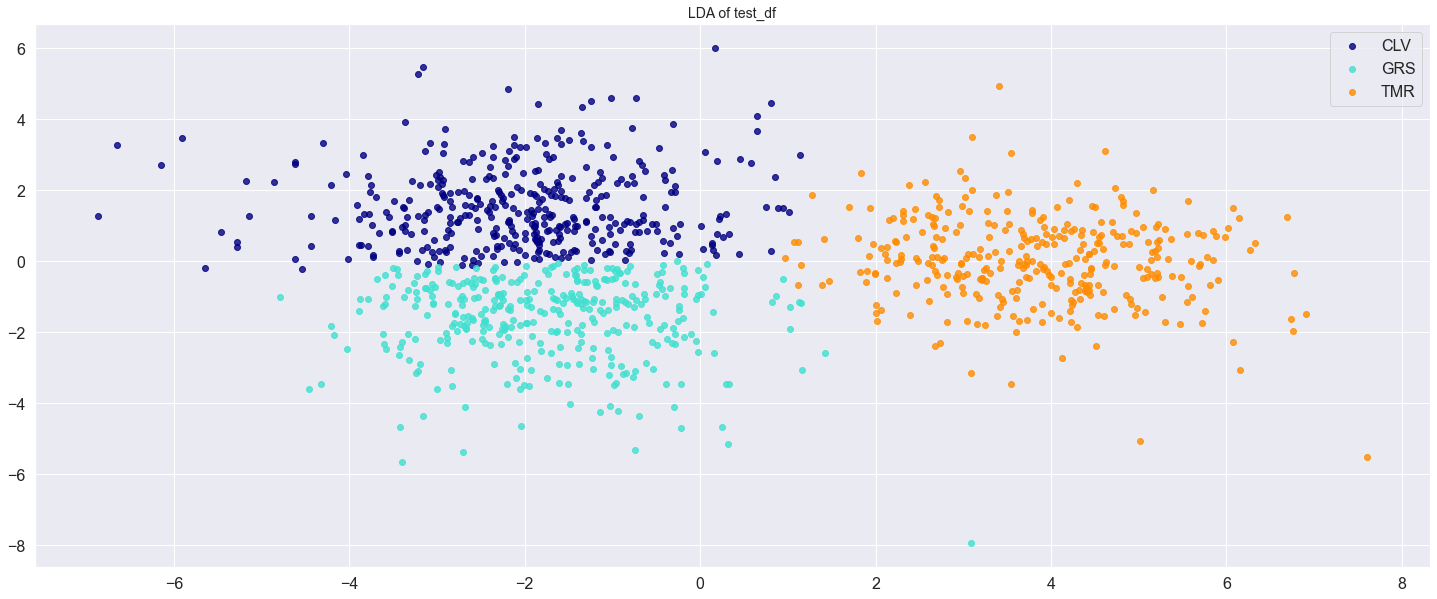

In [68]:
# Visualise the test data according to the 2 LDA components trained above
X_r2 = clf.fit(X, y).transform(X_test_full)

print(X_r2[:10], "\n", y[:10])

target_names = unique_labels(y_pred_test)

plt.figure(figsize=(25, 10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

labelencoder = LabelEncoder()
yn = labelencoder.fit_transform(y_pred_test)

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[yn == i, 0], X_r2[yn == i, 1], alpha=0.8, color=color, label=target_name)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of test_df")

plt.show()



<ipython-input-105-0c4f2e1d71a7>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(25))


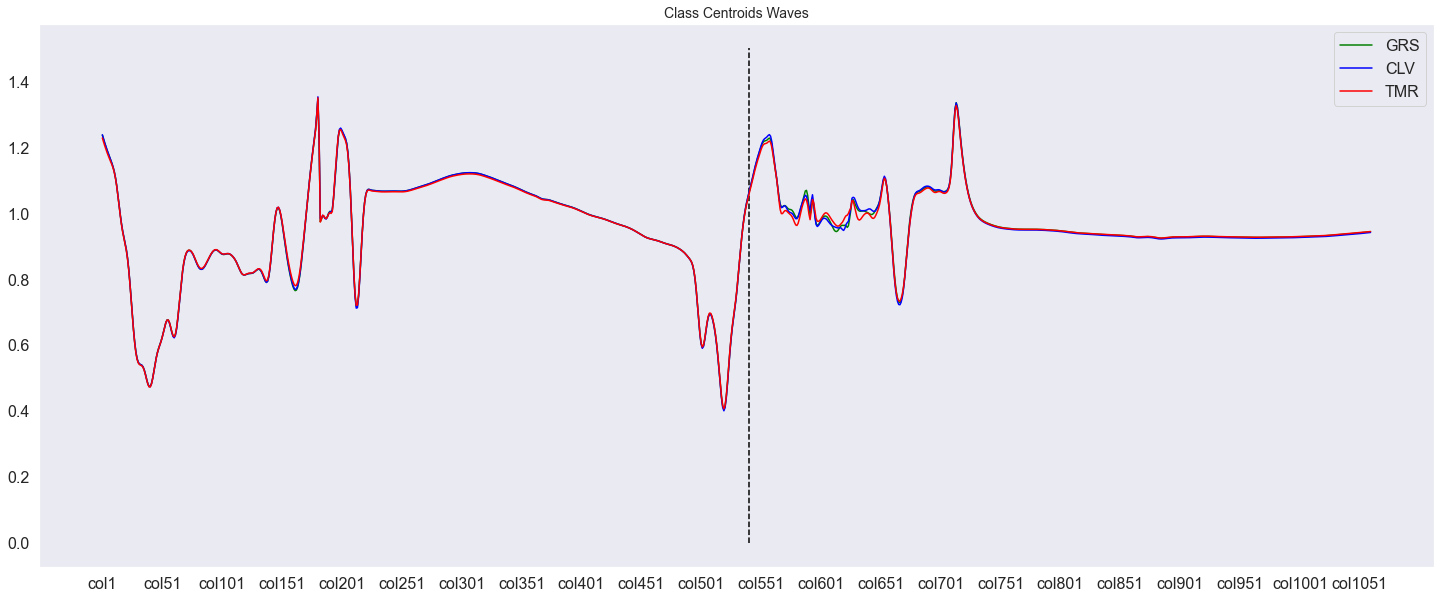

In [105]:
def plotWavesClasses(df, features):
    
    training_GRS = df[df["Diet"] == 'GRS']
    training_CLV = df[df["Diet"] == 'CLV']
    training_TMR = df[df["Diet"] == 'TMR']
    
    plt.figure(figsize=(25, 10))
    
    #plt.plot(df[features].T, color='LightBlue')
    plt.plot(training_GRS[features].mean().T, color='Green', label='GRS')
    plt.plot(training_CLV[features].mean().T, color='Blue', label='CLV')
    plt.plot(training_TMR[features].mean().T, color='Red', label='TMR')
    
    #plt.xticks(rotation=45, ha='right')
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(25))
    plt.vlines(540, ymin=0, ymax=1.5, color='black', linestyle='--')
    #plt.vlines(720, ymin=0, ymax=1.5, color='black', linestyle='--')

    plt.title('Class Centroids Waves')
    plt.legend()
    plt.grid()
    

if __name__ == "__main__":
    plotWavesClasses(df = training_df, features = features)

<ipython-input-105-0c4f2e1d71a7>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(25))


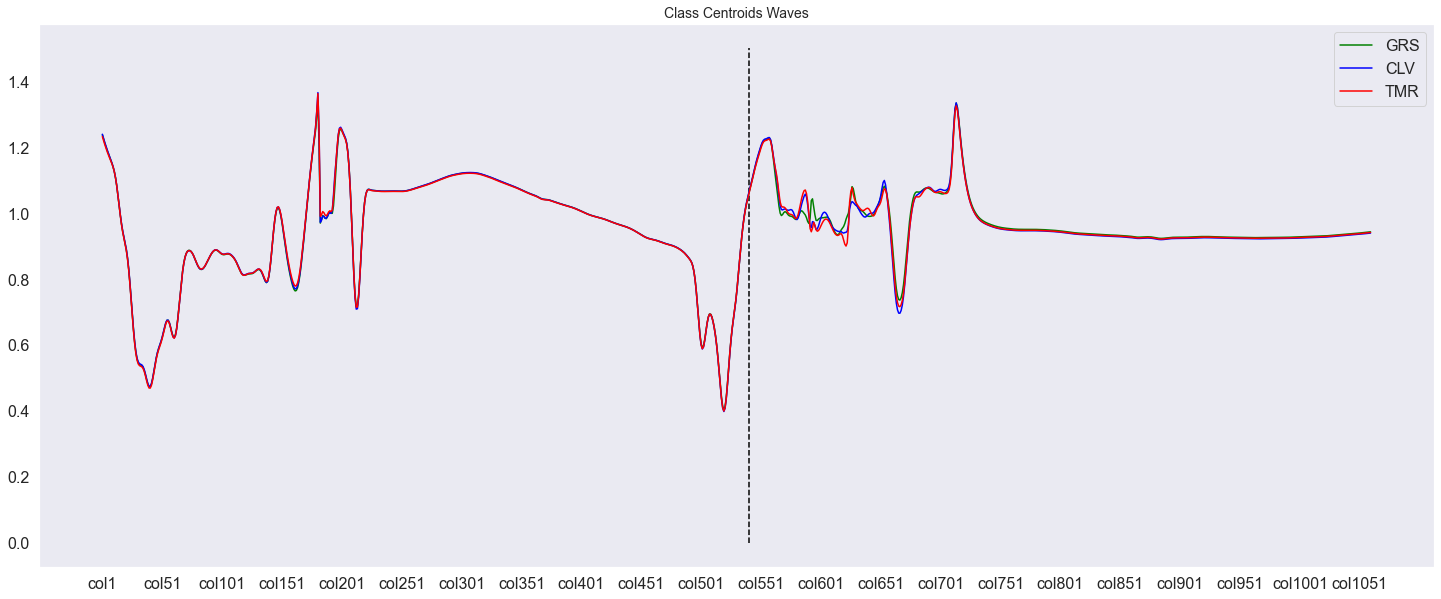

In [106]:
plotWavesClasses(df = test_df_pred, features = test_df_pred.columns)

In [107]:
training_df.shape


(3244, 1061)

In [108]:
target = 'GRS' 
df_target = training_df[training_df['Diet'] == target]
df_target.shape

(1082, 1061)

<ipython-input-113-e63373e19ba2>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


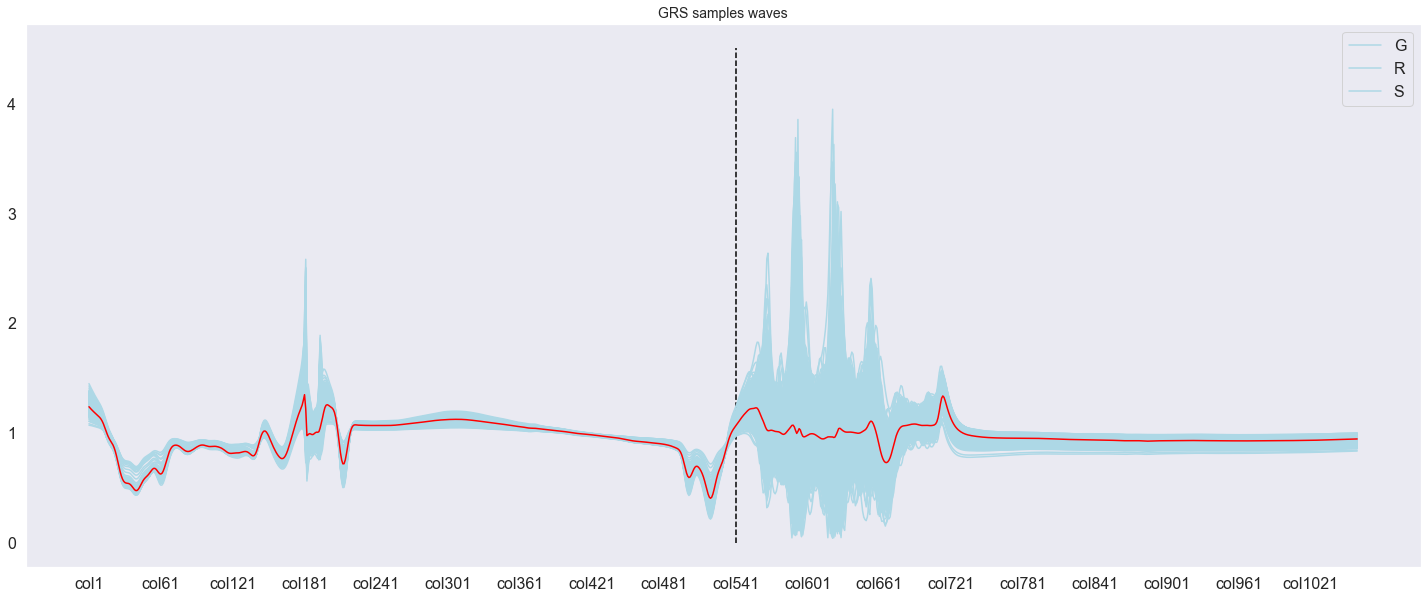

In [113]:
def plotWavesTarget(df, features, target='GRS'):
    
    plt.figure(figsize=(25, 10))
    df_target = df[df['Diet'] == target]
    
    plt.plot(df_target[features].T, color='LightBlue')
    plt.plot(df_target[features].mean().T, color='Red')
    #plt.plot(df_sorted[features].iloc[0:1000].T)
    #plt.plot(df_sorted[features].iloc[0:100].T)
    #plt.plot(df_sorted[features].iloc[[100]].T)
    
    #plt.xticks(rotation=45, ha='right')
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.vlines(540, ymin=0, ymax=4.5, color='black', linestyle='--')
   # plt.vlines(720, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.title(target + ' samples waves')
    plt.legend(target)
    plt.grid()
    

if __name__ == "__main__":
    plotWavesTarget(df = training_df, features = features, target = 'GRS')
    

<ipython-input-113-e63373e19ba2>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


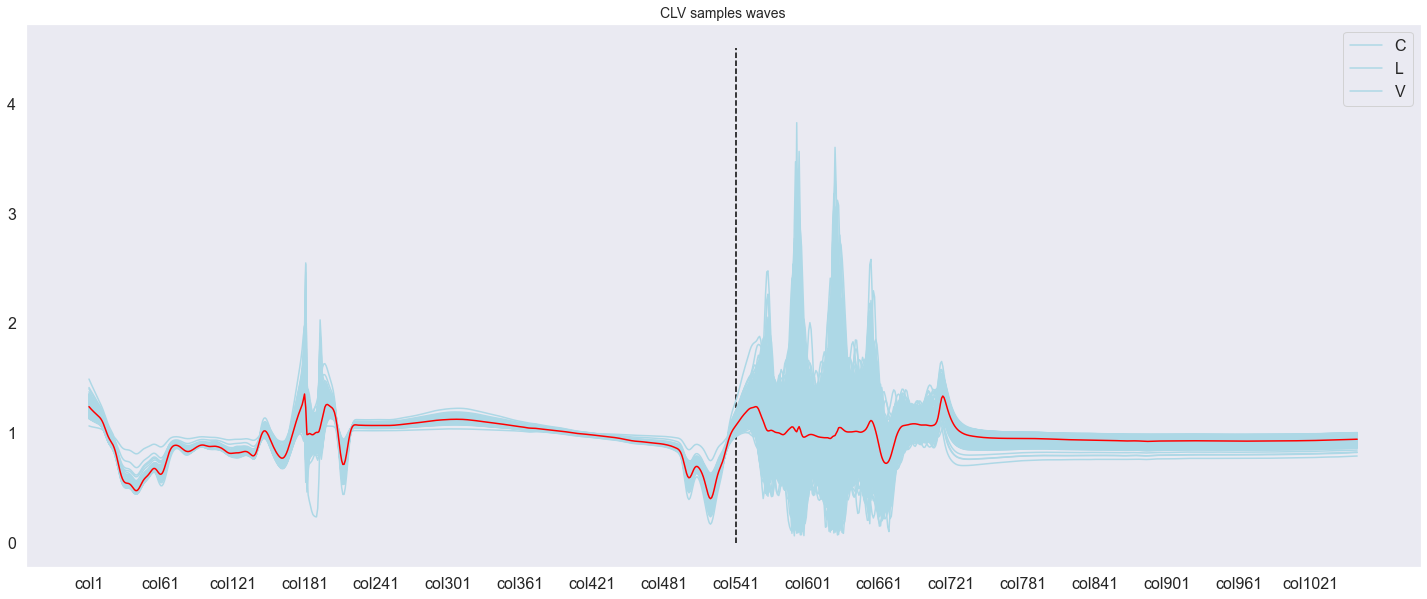

In [114]:
plotWavesTarget(df = training_df, features = features, target = 'CLV')

<ipython-input-113-e63373e19ba2>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


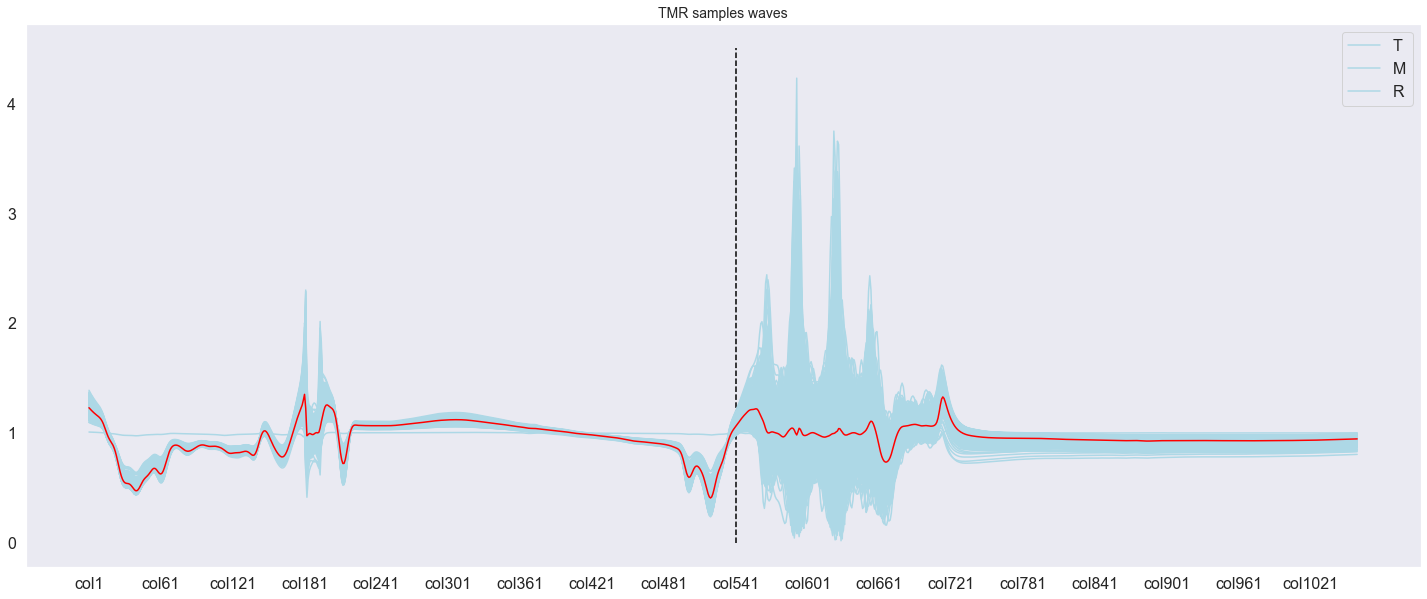

In [115]:
plotWavesTarget(df = training_df, features = features, target = 'TMR')

<ipython-input-117-b8780c9bf67b>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
No handles with labels found to put in legend.


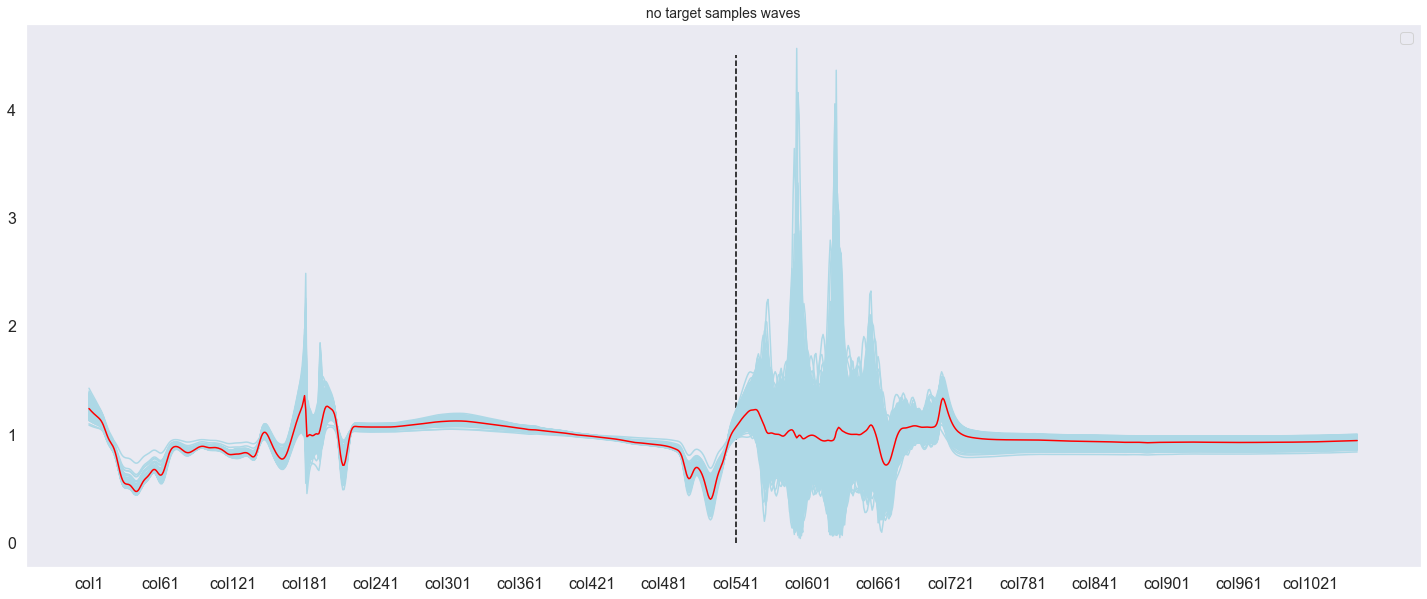

In [117]:
 def plotWavesNoTarget(df, features):

    plt.figure(figsize=(25, 10))
    
    plt.plot(df[features].T, color='LightBlue')
    plt.plot(df[features].mean().T, color='Red')
    #plt.plot(df_sorted[features].iloc[0:1000].T)
    #plt.plot(df_sorted[features].iloc[0:100].T)
    #plt.plot(df_sorted[features].iloc[[100]].T)
    
    #plt.xticks(rotation=45, ha='right')
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.vlines(540, ymin=0, ymax=4.5, color='black', linestyle='--')
    #plt.vlines(720, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.title('no target samples waves')
    plt.legend()
    plt.grid()
    

if __name__ == "__main__":
    plotWavesNoTarget(df = test_df, features = test_df.columns)